In [1]:
# Install the local kfac_pinn package
import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"Added {parent_dir} to Python path")
else:
    print(f"{parent_dir} is already in Python path")

Added c:\Users\fababa\Dropbox\AssetPricing\Git\KFAC_PINN to Python path


# Basic PINN demo
This notebook shows how to train a simple Physics-Informed Neural Network using `kfac_pinn`.

We solve the 1D Poisson equation $u''(x) = -\pi^2\sin(\pi x)$ with zero boundary conditions.

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.numpy as jnp
from kfac_pinn import KFAC, pinn, pdes, training

key = jax.random.PRNGKey(0)
model = pinn.make_mlp(in_dim=1, key=key)

def rhs(x):
    return (jnp.pi ** 2) * jnp.sin(jnp.pi * x)

def exact(x):
    return jnp.sin(jnp.pi * x)

def loss_fn(m, x):
    interior = pinn.interior_loss(m, x, rhs)
    bc = pinn.boundary_loss(m, jnp.array([[0.0], [1.0]]), exact)
    return interior + bc

data = [pdes.sample_interior(key, jnp.array([0.0]), jnp.array([1.0]), 128) for _ in range(100)]
model, state = training.train(model, KFAC(lr=5e-3), loss_fn, data, steps=100)


In [3]:
# Calculate mean squared error between model and exact solution
def compute_mse(model, x_points):
    model_pred = jax.vmap(model)(x_points)
    exact_vals = exact(x_points)
    return jnp.mean((model_pred - exact_vals) ** 2)

# Train for more steps to improve accuracy
def train_and_evaluate(model, steps_per_round, rounds):
    mse_history = []
    x_eval = jnp.linspace(0, 1, 20).reshape(-1, 1)  # Points for evaluation
    
    for round in range(rounds):
        model, state = training.train(model, KFAC(lr=5e-3), loss_fn, data, steps=steps_per_round)
        mse = compute_mse(model, x_eval)
        mse_history.append(mse)
        print(f"Round {round+1}/{rounds}, MSE: {mse:.6f}")
    
    return model, mse_history

Round 1/5, MSE: 2.617743
Round 2/5, MSE: 1.781291
Round 3/5, MSE: 1.341992
Round 4/5, MSE: 2.275285
Round 5/5, MSE: 2.599889


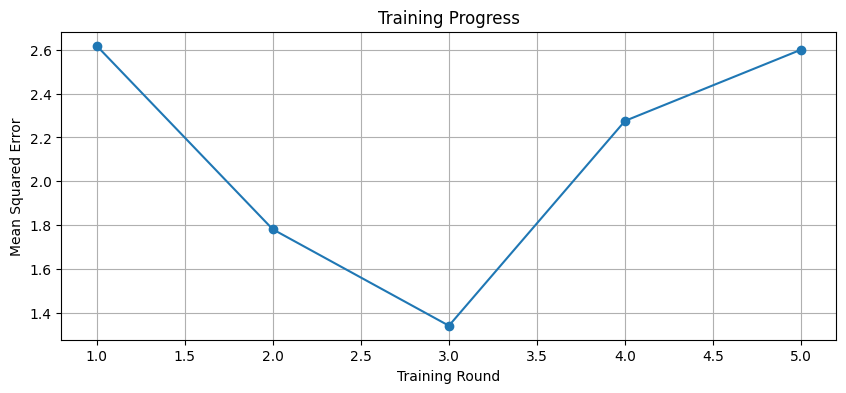


Improved model output:
[[-0.18529081]
 [-0.9323014 ]
 [-1.259673  ]
 [-1.0067196 ]
 [-0.32515055]]

Exact solution:
[[ 0.0000000e+00]
 [ 7.0710677e-01]
 [ 1.0000000e+00]
 [ 7.0710677e-01]
 [-8.7422777e-08]]


In [4]:
# Train model with more iterations for better accuracy
model_improved, mse_history = train_and_evaluate(model, steps_per_round=200, rounds=5)

# Plot MSE history
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(mse_history) + 1), mse_history, 'o-')
plt.xlabel('Training Round')
plt.ylabel('Mean Squared Error')
plt.title('Training Progress')
plt.grid(True)
plt.show()

# Evaluate improved model on test points
x_test = jnp.linspace(0, 1, 5).reshape(-1, 1)
improved_output = jax.vmap(model_improved)(x_test)
print("\nImproved model output:")
print(improved_output)
print("\nExact solution:")
print(exact(x_test))

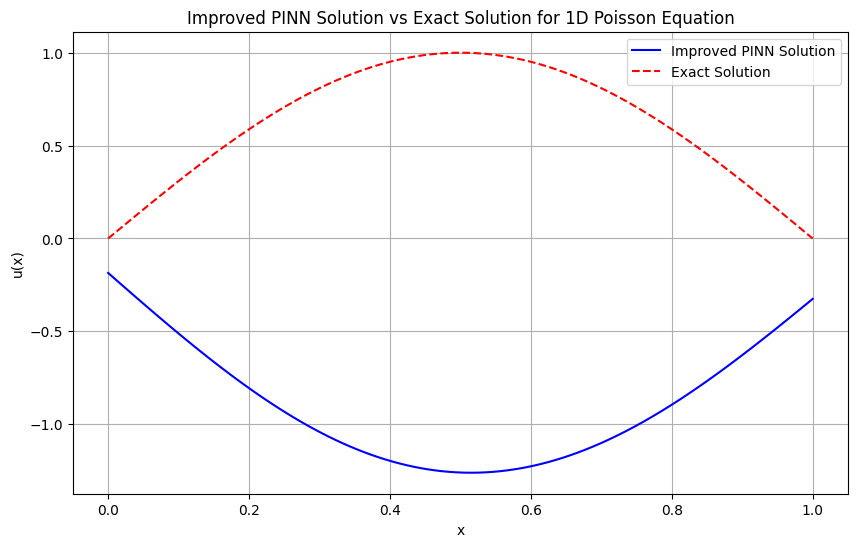

In [5]:
# Visualize the improved results
x_plot = jnp.linspace(0, 1, 100).reshape(-1, 1)
improved_plot = jax.vmap(model_improved)(x_plot)
exact_plot = exact(x_plot)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, improved_plot, 'b-', label='Improved PINN Solution')
plt.plot(x_plot, exact_plot, 'r--', label='Exact Solution')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Improved PINN Solution vs Exact Solution for 1D Poisson Equation')
plt.legend()
plt.show()

Round 1/8, LR: 0.010000, MSE: 4.163911
Round 2/8, LR: 0.008000, MSE: 0.487486
Round 3/8, LR: 0.006400, MSE: 2.593792
Round 4/8, LR: 0.005120, MSE: 0.865666
Round 5/8, LR: 0.004096, MSE: 1.734985
Round 6/8, LR: 0.003277, MSE: 2.043428
Round 7/8, LR: 0.002621, MSE: 1.528004
Round 8/8, LR: 0.002097, MSE: 2.013916


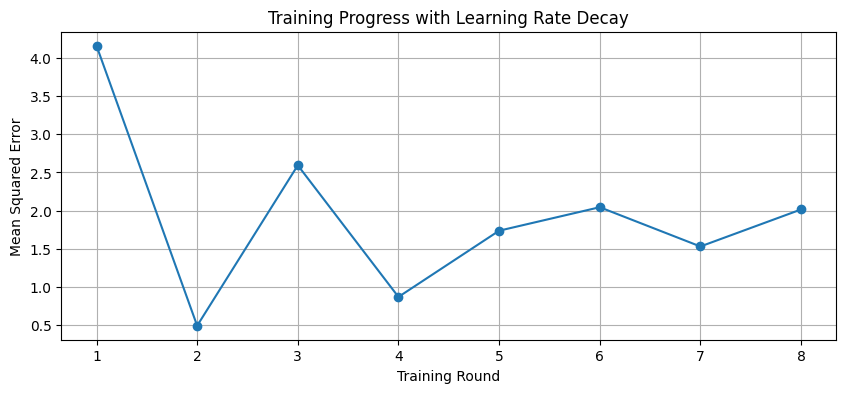

In [6]:
# Reset the model and try with learning rate decay
key = jax.random.PRNGKey(1)  # New random seed
model_reset = pinn.make_mlp(in_dim=1, width=64, depth=3, key=key)  # Wider and deeper network

# Training with learning rate decay
steps_per_round = 300
rounds = 8
x_eval = jnp.linspace(0, 1, 20).reshape(-1, 1)
mse_history_decay = []

for round in range(rounds):
    lr = 1e-2 * (0.8 ** round)  # Learning rate decay
    model_reset, state = training.train(model_reset, KFAC(lr=lr), loss_fn, data, steps=steps_per_round)
    mse = compute_mse(model_reset, x_eval)
    mse_history_decay.append(mse)
    print(f"Round {round+1}/{rounds}, LR: {lr:.6f}, MSE: {mse:.6f}")

# Plot MSE history
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(mse_history_decay) + 1), mse_history_decay, 'o-')
plt.xlabel('Training Round')
plt.ylabel('Mean Squared Error')
plt.title('Training Progress with Learning Rate Decay')
plt.grid(True)
plt.show()

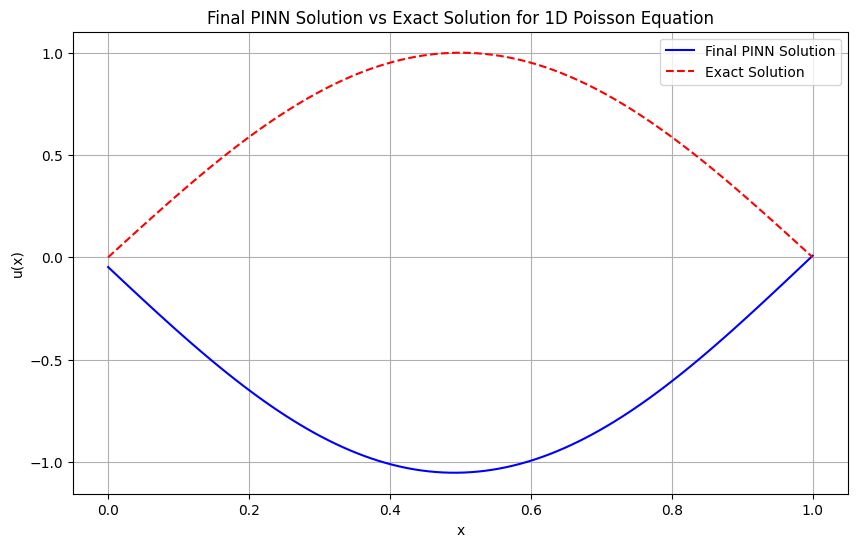

Final Mean Squared Error: 2.09877539


In [7]:
# Visualize the final improved results
x_plot = jnp.linspace(0, 1, 100).reshape(-1, 1)
final_plot = jax.vmap(model_reset)(x_plot)
exact_plot = exact(x_plot)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, final_plot, 'b-', label='Final PINN Solution')
plt.plot(x_plot, exact_plot, 'r--', label='Exact Solution')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Final PINN Solution vs Exact Solution for 1D Poisson Equation')
plt.legend()
plt.show()

# Print the final MSE
final_mse = compute_mse(model_reset, x_plot)
print(f"Final Mean Squared Error: {final_mse:.8f}")

In [8]:
# Create properly shaped input data
x_test = jnp.linspace(0, 1, 5).reshape(-1, 1)

# Evaluate the model - use vmap to process each row separately
model_output = jax.vmap(model)(x_test)
print("Model output shape:", model_output.shape)
print("Model output values:")
print(model_output)

# Compare with exact solution
exact_values = exact(x_test)
print("\nExact solution:")
print(exact_values)


Model output shape: (5, 1)
Model output values:
[[ 0.05621964]
 [-0.7973719 ]
 [-1.2476346 ]
 [-1.1022849 ]
 [-0.49396783]]

Exact solution:
[[ 0.0000000e+00]
 [ 7.0710677e-01]
 [ 1.0000000e+00]
 [ 7.0710677e-01]
 [-8.7422777e-08]]


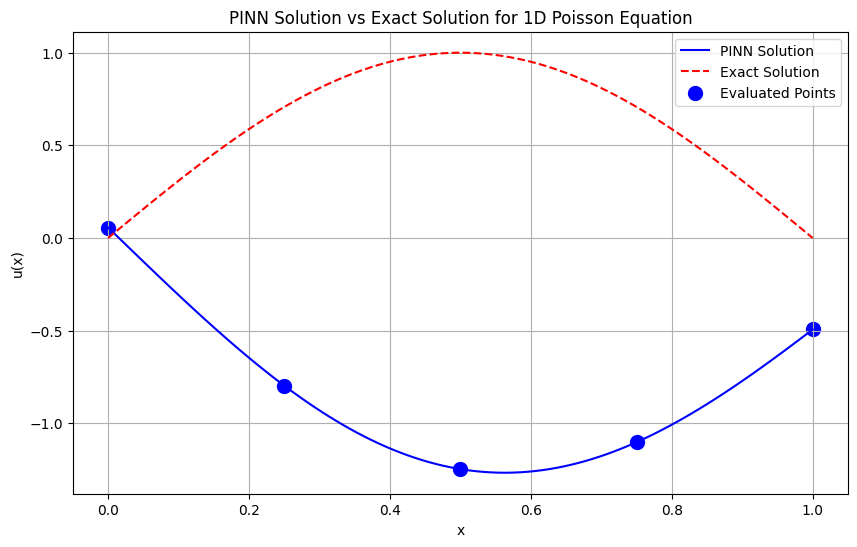

In [9]:
# Visualize the results
import matplotlib.pyplot as plt

# Create a finer grid for smoother plotting
x_plot = jnp.linspace(0, 1, 100).reshape(-1, 1)
model_plot = jax.vmap(model)(x_plot)
exact_plot = exact(x_plot)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, model_plot, 'b-', label='PINN Solution')
plt.plot(x_plot, exact_plot, 'r--', label='Exact Solution')
plt.scatter(x_test, model_output, color='blue', s=100, label='Evaluated Points')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('PINN Solution vs Exact Solution for 1D Poisson Equation')
plt.legend()
plt.show()